In [7]:
import sys
import os
__file__ = %pwd
sys.path.append(os.path.dirname(os.path.dirname(__file__)))
from __init__ import *
print('pwd:', __file__)
logger.setLevel(logging.INFO)

pwd: /homes/David_Li/Mega/University_of_Adelaide/Works/Project/CorrelationV0.1


In [8]:
part_DATASETs = UNIVARIATE_DATASET_NAMES
from CODE.Train.correlated_inception_time import *

model_class = try5_c_Classfier

In [9]:
keys = []
for k in sys.modules.keys():
    if "CODE.Attack.mix" in k:
        print(k)
        keys.append(k)
for k in keys:
    del sys.modules[k]

from CODE.Attack.mix import Mix

attack_model = Mix

CODE.Attack.mix


In [10]:
# trainer = Trainer(model=model_class)

# for i, i_dataset in enumerate(part_DATASETs):
#     attacker = attack_model(
#         train_method_path=trainer.method_path,
#         dataset=i_dataset,
#         model=model_class,
#     )
#     _ = os.path.dirname(attacker.model_weight_path)
#     # check if csv file esists
#     while not os.path.exists(os.path.join(_, "test_metrics.csv")):
#         time.sleep(1)
#     attacker.perturb_all(
#         to_device=True,
#         override=True,
#     )
#     print(i, i_dataset)
#     pprint(attacker.data)
#     print("\n")

In [38]:
dataset_index = 7
data_index = 1

In [39]:
trainer = Trainer(model=model_class)
attacker = attack_model(
    train_method_path=trainer.method_path,
    dataset=part_DATASETs[dataset_index],
    model=model_class,
)

<class 'CODE.Train.correlated_inception_time.try5_c_Classfier'>


In [40]:
default_trainer = Trainer()
default_attacker = attack_model(
    train_method_path=default_trainer.method_path,
    dataset=part_DATASETs[dataset_index],
)

Classifier_INCEPTION


In [42]:
perturbed_file = os.path.join(attacker.out_dir, "x_perturb.tsv")
perturbed_data = np.loadtxt(perturbed_file)[:, 1:]
perturbed_sample = perturbed_data[data_index]  # 选择一个样本
perturbed_sample_tensor = (
    torch.from_numpy(perturbed_sample)
    .unsqueeze(0)
    .unsqueeze(0)
    .to(attacker.device)
    .float()
)

origin_file = os.path.join(
    DATASET_PATH, attacker.dataset, f"{attacker.dataset}_TEST.tsv"
)
origin_data = np.loadtxt(origin_file)[:, 1:]
origin_sample = origin_data[data_index]  # 选择一个样本
origin_sample_tensor = (
    torch.from_numpy(origin_sample)
    .unsqueeze(0)
    .unsqueeze(0)
    .to(attacker.device)
    .float()
)

default_attacker.f(perturbed_sample_tensor)
default_attacker.f(origin_sample_tensor)

tensor([[9.9994e-01, 1.3119e-06, 2.0466e-05, 2.6508e-05, 9.5391e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

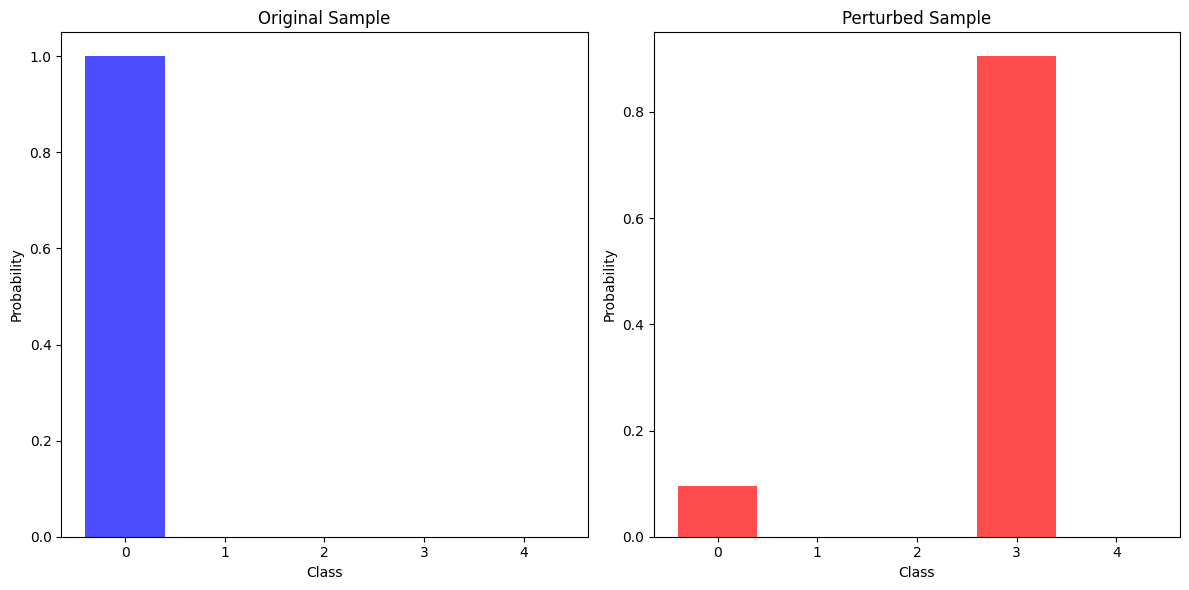

In [43]:
with torch.no_grad():  # 确保不计算梯度
    original_probs = attacker.f(origin_sample_tensor).squeeze(0).cpu().numpy()
    perturbed_probs = attacker.f(perturbed_sample_tensor).squeeze(0).cpu().numpy()

# 创建对比图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(
    range(len(original_probs)),
    original_probs,
    color="blue",
    alpha=0.7,
    label="Original",
)
plt.title(f"Original Sample")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.bar(
    range(len(perturbed_probs)),
    perturbed_probs,
    color="red",
    alpha=0.7,
    label="Perturbed",
)
plt.title(f"Perturbed Sample")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

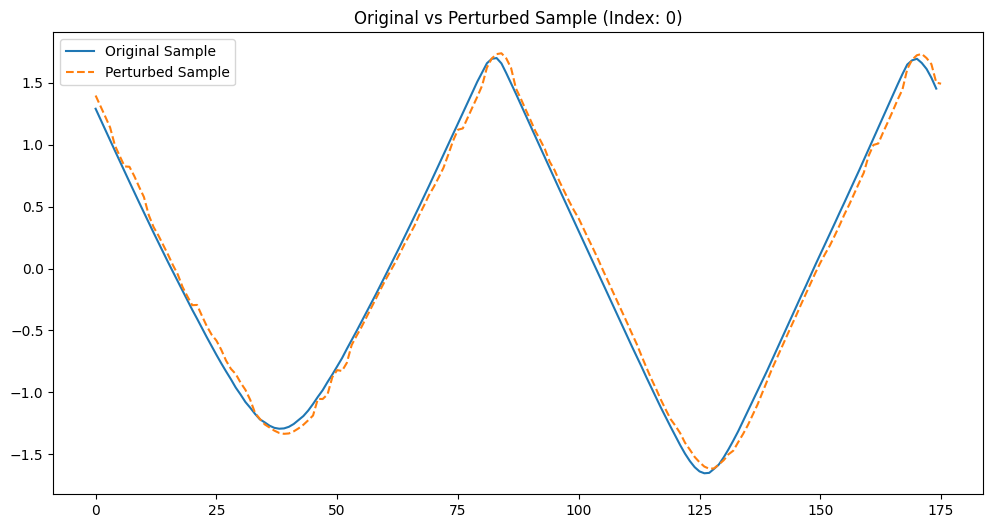

In [18]:
attacker.plot_comparison(0)

In [44]:
import numpy as np
import torch


def calculate_attack_success_rate(
    attacker,
    trainer,
    default_trainer,
    dataset_index,
    model_class,
    part_DATASETs,
    DATASET_PATH,
):
    # 初始化两个模型
    trainer = Trainer(model=model_class)
    default_trainer = Trainer()

    # 创建攻击者
    attacker = attack_model(
        train_method_path=trainer.method_path,
        dataset=part_DATASETs[dataset_index],
        model=model_class,
    )
    default_attacker = attack_model(
        train_method_path=default_trainer.method_path,
        dataset=part_DATASETs[dataset_index],
    )

    # 读取扰动样本
    perturbed_file = os.path.join(attacker.out_dir, "x_perturb.tsv")
    perturbed_data = np.loadtxt(perturbed_file)[:, 1:]

    # 读取原始样本
    origin_file = os.path.join(
        DATASET_PATH, attacker.dataset, f"{attacker.dataset}_TEST.tsv"
    )
    origin_data = np.loadtxt(origin_file)[:, 1:]

    success_count = 0
    total_count = 0

    for data_index in range(len(perturbed_data)):
        # 选择样本
        perturbed_sample = perturbed_data[data_index]
        origin_sample = origin_data[data_index]

        # 转换为张量
        perturbed_sample_tensor = (
            torch.from_numpy(perturbed_sample)
            .unsqueeze(0)
            .unsqueeze(0)
            .to(attacker.device)
            .float()
        )
        origin_sample_tensor = (
            torch.from_numpy(origin_sample)
            .unsqueeze(0)
            .unsqueeze(0)
            .to(attacker.device)
            .float()
        )

        # 获取预测结果
        with torch.no_grad():
            perturbed_pred = torch.argmax(default_attacker.f(perturbed_sample_tensor))
            origin_pred = torch.argmax(default_attacker.f(origin_sample_tensor))

        # 检查是否攻击成功
        if perturbed_pred != origin_pred:
            success_count += 1
        total_count += 1

    # 计算攻击成功率
    success_rate = success_count / total_count
    return success_rate


# 示例调用（确保传递正确的参数）
# success_rate = calculate_attack_success_rate(..., ..., ..., dataset_index, model_class, part_DATASETs, DATASET_PATH)
# print("Attack Success Rate:", success_rate)

In [46]:
calculate_attack_success_rate(
    attacker,
    trainer,
    default_trainer,
    2,
    model_class,
    part_DATASETs,
    DATASET_PATH,
)

<class 'CODE.Train.correlated_inception_time.try5_c_Classfier'>
Classifier_INCEPTION


0.5757142857142857